In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
import csv

# Set the maximum field size allowed in CSV
# to the maximum size supported by the system
csv.field_size_limit(sys.maxsize)

131072

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Reading the 'zomato.csv' file
df = pd.read_csv('/content/drive/MyDrive/zomato.csv',
                 engine='python', on_bad_lines='skip', encoding='utf-8')

In [4]:
# Dropping unnecessary columns
df = df.drop(['url', 'phone', 'dish_liked', 'menu_item', 'listed_in(city)'], axis=1)

# Renaming columns for better readability and consistency
df = df.rename(columns={'approx_cost(for two people)':'cost',
                        'listed_in(type)':'type'})

# Capitalizing the first letter of each word in the 'name' column
df.name = df.name.apply(lambda x:x.title())

# Converting 'online_order' and 'book_table' columns to Boolean True/False
df.online_order.replace(('Yes','No'),(True, False),inplace=True)
df.book_table.replace(('Yes','No'),(True, False),inplace=True)

# Cleaning and converting the 'cost' column to a float type
df['cost'] = df['cost'].astype(str)
df['cost'] = df['cost'].apply(lambda x: x.replace(',','.'))
df['cost'] = df['cost'].astype(float)

# Removing rows where 'rate' is 'NEW' or '-'
df = df.loc[df.rate !='NEW']
df = df.loc[df.rate !='-'].reset_index(drop=True)

# Removing the '/5' part from the 'rate' column and converting it to float
remove_slash = lambda x: x.replace('/5', '') if isinstance(x, str) else x
df.rate = df.rate.apply(remove_slash).str.strip().astype('float')

In [5]:
### Content-Based Recommendation System Using TF-IDF Vectorization & Cosine Similarity

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Creating a list of custom stop words.
# english stop words & "rated"
custom_stop_words = list(TfidfVectorizer(stop_words='english').get_stop_words()) + ['rated']

# instance of TfidfVectorizer, specifying the custom stop words to use
# This vectorizer will be used to transform text into a certain form to use.
tfidf_vectorizer = TfidfVectorizer(stop_words=custom_stop_words)

# Transforming the 'reviews_list' column of the DataFrame into a TF-IDF-weighted term-document matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(df['reviews_list'])

# Calculating the cosine similarity matrix from the TF-IDF matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

def get_recommendations(df, title):

    # Finding the index of the restaurant that matches the title
    idx = df.index[df['name'] == title].tolist()[0]

    # Getting the pairwise similarity scores
    # of all restaurants with that restaurant
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sorting the restaurants based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Filtering out the same restaurant
    # to avoid self-recommendation
    sim_scores = [score for score in sim_scores if df['name'].iloc[score[0]] != title]

    recommended_restaurants = []
    seen_names = set()
    for score in sim_scores:
        # Limit the number of recommendations to 5
        if len(recommended_restaurants) == 5:
            break
        restaurant_name = df['name'].iloc[score[0]]

        # Ensuring no duplicate recommendations
        if restaurant_name not in seen_names:
            recommended_restaurants.append(restaurant_name)
            seen_names.add(restaurant_name)

    return recommended_restaurants

df_copied = df.copy()

# Random select for the target restaurant
target_restaurant_name = np.random.choice(df['name'].unique())

print("target_restaurant: " + target_restaurant_name)

# Scenario: Getting recommendations for the randomly chosen restaurant
recommended_restaurants = get_recommendations(df_copied, target_restaurant_name)

recommended_restaurants

target_restaurant: Chef All Nite


['Masala Central',
 'Bendakaluru Bytes',
 'Chinese Street',
 'New Punjabi Tasty Khana',
 'Hot Coffee']

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# returns the indices of the given restaurant names
def get_indices(df, restaurant_names):
    return [df.index[df['name'] == name].tolist()[0] for name in restaurant_names]

# find the common words between two restaurants
# based on their TF-IDF vectors and returns weight
def get_common_words_weights(tfidf_matrix, index1, index2, feature_names):
    vector1 = tfidf_matrix[index1].toarray().flatten()
    vector2 = tfidf_matrix[index2].toarray().flatten()
    common_words = np.where((vector1 > 0) & (vector2 > 0))[0]
    weights = [(feature_names[word], vector1[word], vector2[word]) for word in common_words]
    weights.sort(key=lambda x: -min(x[1], x[2]))
    return weights

# plot a bar chart comparing the TF-IDF weights of common words
def plot_bar_chart(labels, weights1, weights2, title, label1, label2):
    x = np.arange(len(labels))
    width = 0.35
    fig, ax = plt.subplots()
    ax.bar(x - width/2, weights1, width, label=label1)
    ax.bar(x + width/2, weights2, width, label=label2)
    ax.set_ylabel('TF-IDF Weights'), ax.set_title(title)
    ax.set_xticks(x), ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.legend()
    plt.show()

# create a word cloud visualization for the given weights
def plot_wordcloud(weights, title, width=400, height=400):
    wordcloud = WordCloud(width=width, height=height, background_color='white', min_font_size=10).generate_from_frequencies(dict(weights))
    plt.figure(figsize=(width/100, height/100), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.tight_layout(pad=0)
    plt.show()

recommended_indices = get_indices(df, recommended_restaurants)
target_restaurant_name_idx = df.index[df['name'] == target_restaurant_name].tolist()[0]
feature_names = tfidf_vectorizer.get_feature_names_out()

In [ ]:
for idx in recommended_indices:
    # Get the common words and their TF-IDF weights
    common_words_weights = get_common_words_weights(tfidf_matrix, target_restaurant_name_idx, idx, feature_names)

    # Selecting the top 5 common words for comparison
    top_words = common_words_weights[:7]

    # Unpack the word labels and their corresponding weights
    labels, weights_target_restaurant, weights_restaurant = zip(*top_words)

    plot_bar_chart(labels, weights_target_restaurant, weights_restaurant, f'Common words in reviews: target_restaurant vs {df["name"].iloc[idx]}', 'target_restaurant', df['name'].iloc[idx])

    print()

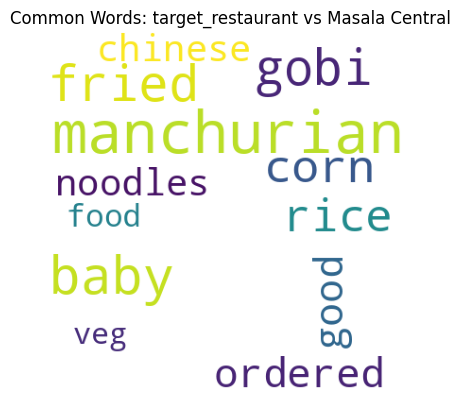

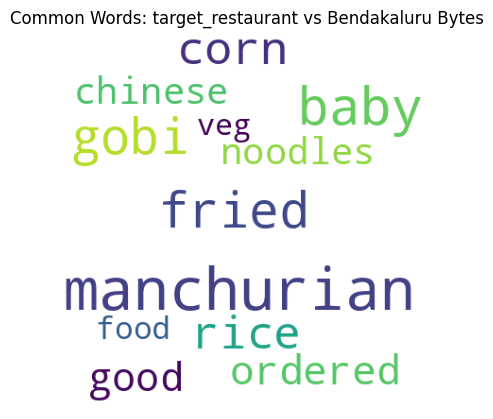

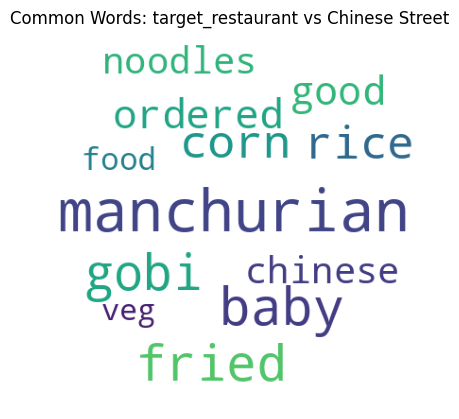

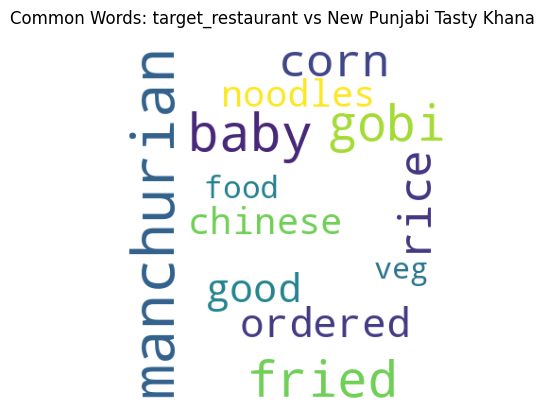

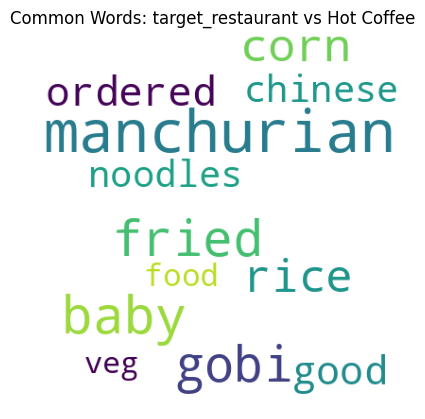

In [28]:
for idx in recommended_indices:
    # Calculate the average weights for the common words
    common_words_avg_weights = {word: (weight1 + weight2) / 2 for word, weight1, weight2 in common_words_weights}

    # Create a word cloud visualization for these average weights
    plot_wordcloud(common_words_avg_weights, f'Common Words: target_restaurant vs {df["name"].iloc[idx]}')

    print()